In [9]:
import requests
import glob
import io
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from influxdb import InfluxDBClient

In [56]:
nycd = gpd.read_file('nycd_21c/nycd.shp').to_crs('EPSG:4326')

In [71]:
sensors = pd.read_csv('sensor_locations.csv')
sensors = gpd.GeoDataFrame(sensors, geometry=gpd.points_from_xy(sensors['lng'], sensors['lat'], crs='EPSG:4326'))

In [74]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211001T0000/20211002T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent&variables[]=lat@degrees&variables[]=lon@degrees')
stations = pd.read_csv(io.StringIO(r.text))
stations = stations.rename(columns={'lat [degrees]':'lat', 'lon [degrees]':'lon'})

In [77]:
stations = stations.groupby('station')[['lat','lon']].mean().reset_index()
stations.to_csv('micronet_stations.csv', index=False)

In [79]:
stations = gpd.GeoDataFrame(stations, geometry=gpd.points_from_xy(stations['lon'], stations['lat'], crs='EPSG:4326'))

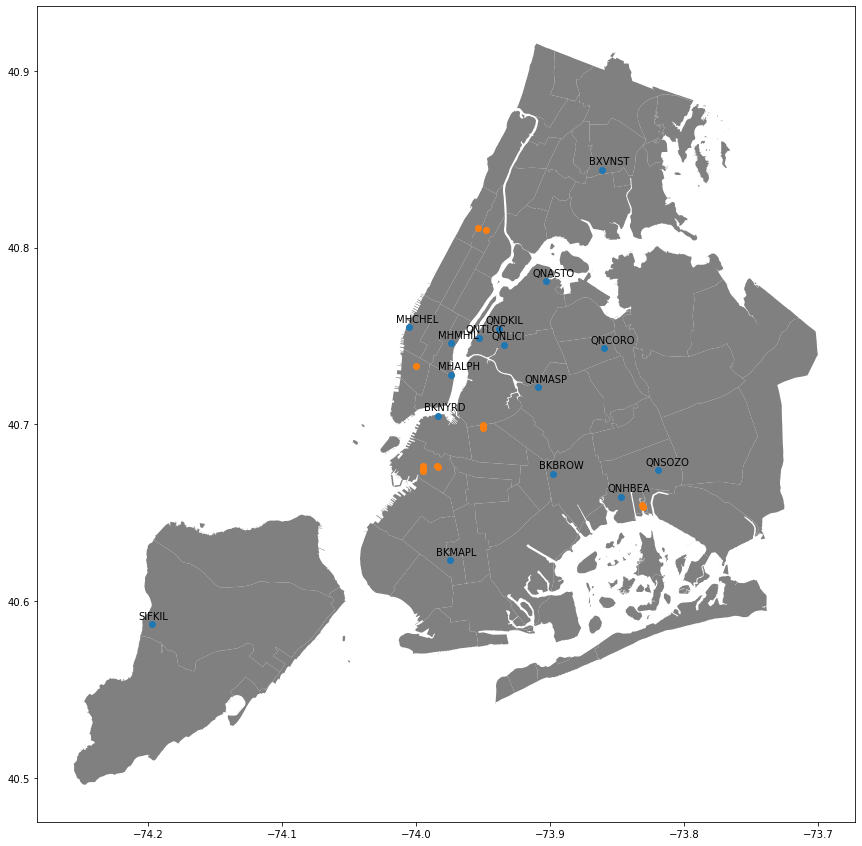

In [143]:
fig, ax = plt.subplots(figsize=(15,15))

nycd.plot(ax=ax, color='gray')
stations.plot(ax=ax, label=stations.station)
sensors.plot(ax=ax)
for i in range(len(stations)):
    plt.annotate(stations.station[i], (stations.lon[i] - 0.01, stations.lat[i] +0.003))

#### Retrieve Data from Mesonet API (This only needs to be done once but should grabbing data at least once a day)

In [116]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20201101T0000/20201201T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2020_11.csv')


In [ ]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20201201T0000/20210101T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2020_12.csv')


In [95]:
## Download 2021 Data

month_dict = {}
year = '2021'
for month in range(1,12):
    month2 = str(month+1).zfill(2)
    month = str(month).zfill(2)
    
    print('Querying Month '+month)
    
    r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/'+year+month+'01T0000/'+year+month2+'01T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
    df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
    #df = df.groupby('datetime', as_index=False).median().iloc[:-1]
    df.to_csv('micronet_temp2021_'+month+'.csv')
    month_dict[month] = df
    
                 

Querying Month 01
Querying Month 02
Querying Month 03
Querying Month 04
Querying Month 05
Querying Month 06
Querying Month 07
Querying Month 08
Querying Month 09
Querying Month 10
Querying Month 11


In [104]:
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211201T0000/20220101T0000?stations=bkbrow,bkmapl,bknyrd,bxvnst,mhalph,mhchel,mhmhil,qnasto,qncoro,qndkil,qnhbea,qnlici,qnmasp,qnsozo,qntlcc,sifkil&timezone=America/New_York&variables[]=tair@degF&variables[]=relh@percent')
df = pd.read_csv(io.StringIO(r.text)).iloc[:-1]
#df = df.groupby('datetime', as_index=False).median()
df.to_csv('micronet_temp2021_12.csv')

# Merge csvs into single DataFrame

In [118]:
temps = pd.concat(map(pd.read_csv, glob.glob('micronet_weather/*.csv'))).iloc[:,1:].dropna()
temps['datetime'] = pd.to_datetime(temps['datetime'])

//anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
//anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1212: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [122]:
temps = temps.drop_duplicates()

In [124]:
temps.resample('10min', on='datetime').mean() ## resample at 10_min intervals

,temp_2m [degF],relative_humidity [percent]
datetime,,
2020-11-01 00:00:00,45.600000,61.843750
2020-11-01 00:10:00,45.603125,62.118750
2020-11-01 00:20:00,45.556250,62.675000
2020-11-01 00:30:00,45.671875,63.137500
2020-11-01 00:40:00,45.884375,63.206250
...,...,...
2021-12-31 23:20:00,50.718750,91.309375
2021-12-31 23:30:00,50.656250,91.550000
2021-12-31 23:40:00,50.625000,91.959375


In [6]:
tempstemp_2m [degF]	

,datetime,temp_2m [degF],relative_humidity [percent]
0,2020-10-10 00:00:00-04:00,62.9,51.20
1,2020-10-10 00:05:00-04:00,62.8,51.50
2,2020-10-10 00:10:00-04:00,62.8,51.60
3,2020-10-10 00:15:00-04:00,62.5,51.80
4,2020-10-10 00:20:00-04:00,62.5,52.20
...,...,...,...
8528,2021-10-30 14:40:00-04:00,64.7,70.05
8529,2021-10-30 14:45:00-04:00,64.8,69.90
8530,2021-10-30 14:50:00-04:00,65.0,69.80
8531,2021-10-30 14:55:00-04:00,64.8,70.25


In [47]:
Token = 'hkCIxZjujBKMWsCQJvUhoXoCMWnFwLve'
StationID = 'GHCND:USW00014732'

#initialize lists to store data
dates_temp = []
dates_prcp = []
temps = []
prcp = []

#for each year from 2015-2019 ...
for year in range(2020, 2022):
    year = str(year)
    print('working on year '+year)
    
    #make the api call
    r = requests.get('https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TAVG&limit=1000&stationid=GHCND:USW00023129&startdate='+year+'-01-01&enddate='+year+'-12-31', headers={'token':Token})
    #load the api response as a json
    d = di
    #get all items in the response which are average temperature readings
    avg_temps = [item for item in d['results'] if item['datatype']=='TAVG']
    #get the date field from all average temperature readings
    dates_temp += [item['date'] for item in avg_temps]
    #get the actual average temperature from all average temperature readings
    temps += [item['value'] for item in avg_temps]

working on year 2020
working on year 2021


In [116]:
##### Query Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'distance'
table = 'msg'
app_id = 'deployment_one_app'
dev_id = 'sensor_2'
days_back = 380

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

dist = pd.DataFrame(value_data, columns =['datetime', 'distance'])

dist['datetime'] = pd.to_datetime(dist['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
dist['localtime'] = dist['datetime'].dt.tz_convert('US/Eastern')

dist = pd.DataFrame(dist.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(dist)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                      localtime     distance
0     2020-10-14 16:20:00-04:00  2725.000000
1     2020-10-14 16:30:00-04:00  2710.500000
2     2020-10-14 16:40:00-04:00  2716.500000
3     2020-10-14 16:50:00-04:00  2714.333333
4     2020-10-14 17:00:00-04:00  2712.500000
...                         ...          ...
54716 2021-10-29 15:40:00-04:00  2707.666667
54717 2021-10-29 15:50:00-04:00  2701.000000
54718 2021-10-29 16:00:00-04:00  2707.000000
54719 2021-10-29 16:10:00-04:00  2703.000000
54720 2021-10-29 16:20:00-04:00  2698.500000

[54721 rows x 2 columns]


In [3]:
##### Query Sensor Data from InfluxDB

client = InfluxDBClient(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

measure = 'battery'
table = 'msg'
app_id = 'deployment_one_app'
dev_id = 'sensor_2'
days_back = 300

query = 'SELECT "%s" ' \
        'FROM "%s" ' \
        'WHERE "app_id" = \'%s\' ' \
        'AND "dev_id" = \'%s\' ' \
        'AND "time" >= now() - %id'\
        % (measure, table, app_id, dev_id, days_back)

data = client.query(query)

value_data = data.raw['series'][0]['values']

battery = pd.DataFrame(value_data, columns =['datetime', 'battery'])

#battery['datetime'] = pd.to_datetime(dist['datetime'], format='%Y-%m-%dT%H:%M:%S.%f')
#battery['localtime'] = dist['datetime'].dt.tz_convert('US/Eastern')

#battery = pd.DataFrame(dist.resample('10min', on='localtime').distance.mean()).reset_index() ## resample at 10_min intervals

print(battery)

//anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1020: InsecureRequestWarning: Unverified HTTPS request is being made to host 'floodnet-influxdb.sonycproject.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


                          datetime  battery
0      2020-11-14T15:17:31.729012Z    4.241
1      2020-11-14T15:21:42.125054Z    4.247
2      2020-11-14T15:25:52.478309Z    4.247
3      2020-11-14T15:30:02.733798Z    4.247
4      2020-11-14T15:34:12.876767Z    4.247
...                            ...      ...
99363  2021-09-10T14:57:43.084556Z    4.234
99364  2021-09-10T15:01:50.543238Z    4.241
99365  2021-09-10T15:05:57.923244Z    4.241
99366  2021-09-10T15:10:05.257828Z    4.234
99367  2021-09-10T15:14:12.822313Z    4.241

[99368 rows x 2 columns]


In [117]:
## Select only overnight data for analysis

overnight_dist = dist[(dist.localtime.dt.hour > 22) | (dist.localtime.dt.hour < 5)]

# Local Weather Aggregation

In [129]:
def format_weather(data):
    
    winds = ['SW', 'WSW', 'West', 'WNW', 'NW', 'NNW', 'NE', 'East', 'NNE',
    'North', 'SSW', 'ESE', 'South', 'ENE', 'SE', 'SSE']
    wind_deg = [225,247.5,270,292.5,315,337.5,45,90,22.5,0.0,202.5,112.5,180,67.5,135,157.5]
    wind_zip = dict(zip(winds, wind_deg))
   
    from datetime import datetime

    data['Date_Time'] = pd.to_datetime(data['Date_Time'], errors='coerce')
    data = data.rename(columns={'Date_Time':'localtime'})
    data['localtime'] = data['localtime'].dt.tz_localize('EST')
    data['localtime'] = data['localtime'].dt.tz_convert('US/Eastern')
    data['Wind'] = data['Wind'].map(wind_zip)
    
    data = pd.DataFrame(data.resample('10min', on='localtime').mean()).reset_index()

    return data

In [130]:
winds = ['SW', 'WSW', 'West', 'WNW', 'NW', 'NNW', 'NE', 'East', 'NNE',
       'North', 'SSW', 'ESE', 'South', 'ENE', 'SE', 'SSE']
wind_deg = [225,247.5,270,292.5,315,337.5,45,90,22.5,0.0,202.5,112.5,180,67.5,135,157.5]
wind_zip = dict(zip(winds, wind_deg))

directoryPath = 'the-weather-scraper-master/Weather Data/'

weather_1 = pd.read_csv(directoryPath+'KNYGOWAN6.csv', parse_dates=[["Date","Time"]]).dropna()
weather_1 = format_weather(weather_1).dropna()


//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (2,3,4,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [157]:
weather_1 = pd.read_csv(directoryPath+'KNYGOWAN6.csv', parse_dates=[["Date","Time"]], low_memory=False).dropna()

In [158]:
weather_1['Date_Time'] = pd.to_datetime(weather_1['Date_Time'], errors='coerce')
weather_1 = weather_1.rename(columns={'Date_Time':'localtime'})
weather_1['localtime'] = weather_1['localtime'].dt.tz_localize('EST')
weather_1['localtime'] = weather_1['localtime'].dt.tz_convert('US/Eastern')
weather_1 = pd.DataFrame(weather_1.resample('10min', on='localtime').mean()).reset_index()

DataError: No numeric types to aggregate

In [165]:
weather_1.iloc[:,1:] = weather_1.iloc[:,1:].apply(pd.to_numeric, errors='coerce')

In [167]:
weather_1 = pd.DataFrame(weather_1.resample('10min', on='localtime').mean()).reset_index()

In [ ]:
import glob
import pandas as pd

directoryPath = 'the-weather-scraper-master/Weather Data/'

weather_dict = {}
for i, file_name in enumerate(glob.glob(directoryPath+'*.csv')):
    weather_dict[f"weather_{i+1}"] = pd.read_csv(file_name, low_memory=False)

#for key in weather_dict:
        #weather_dict[key] = format_weather(weather_dict[key])

In [ ]:
## resample weather data in 10-minute intervals

weather = pd.DataFrame(weather.resample('10min', on='localtime').mean()).reset_index()

In [204]:
## merge weather and sensor data and drop NaN values

night = overnight_dist.merge(weather_1, on='localtime',how='inner').drop(columns='Wind')
night = night.set_index('localtime').dropna()

<AxesSubplot:xlabel='localtime'>

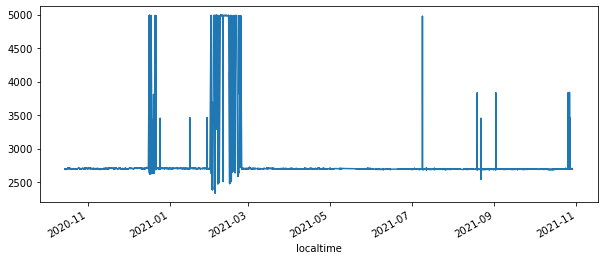

In [206]:
night['distance'].plot(figsize=(10,4))

<AxesSubplot:xlabel='localtime'>

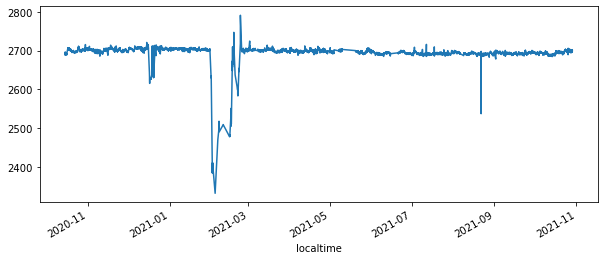

In [207]:
night[(night['distance'] < 2800)]['distance'].plot(figsize=(10,4))

In [218]:
## Drop 5000s, anomalous Snowy February,  December 2020 Flood Event

night_clean = night[night['distance'] < 4500]
night_clean = night_clean[night_clean.index.month != 2] ## Omit Snowy February
night_clean = night_clean[~(night_clean.index.date == pd.Timestamp(month=1, year=2021, day=31))]# Remove 1/31 - also snowy

night_clean = night_clean[(night_clean.index.date < pd.Timestamp(year=2020, month=12, day=15))\
| (night_clean.index.date > pd.Timestamp(year=2020, month=12, day=22))] # Omit December Flood Event

<AxesSubplot:xlabel='localtime'>

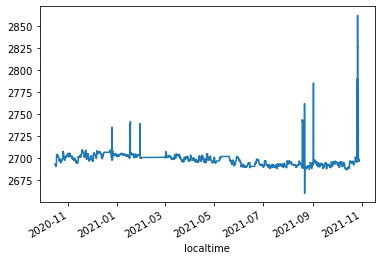

In [219]:
night_clean['distance'].rolling(21, ).mean().plot()

In [220]:
lower = night_clean['distance'].mean() - 2*(night_clean['distance'].std())
upper = night_clean['distance'].mean() + 2*(night_clean['distance'].std())

In [221]:
### Remove readings 3STDs from mean distance
night_clean = night_clean[night_clean['distance'] < upper]
night_clean = night_clean[night_clean['distance'] > lower]

<AxesSubplot:xlabel='localtime'>

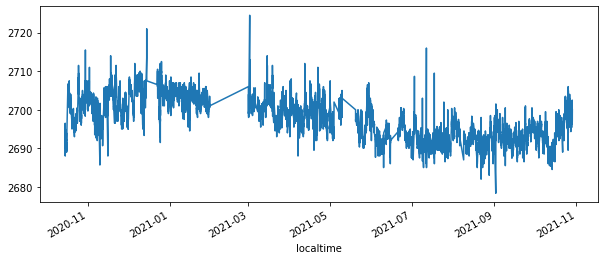

In [222]:
night_clean['distance'].plot(figsize=(10,4))

In [223]:
pd.pivot_table(data=night, columns=night.index.month, values=['distance','Temperature_C', 'Humidity_%'], aggfunc='mean')

localtime,1,2,3,4,5,6,7,8,9,10,11,12
Humidity_%,71.217937,73.110338,65.050049,66.569208,71.875618,81.660301,82.715054,82.342912,79.771084,84.532628,73.954650,74.708371
Temperature_C,1.161265,0.883772,6.352619,10.381815,15.451326,21.879497,23.486425,24.223477,20.887790,15.412233,9.948016,3.757730
distance,2716.977728,3978.911365,2700.807742,2699.126546,2697.242449,2693.707176,2694.014785,2694.042784,2694.939914,2699.806344,2701.292818,2813.815742


In [232]:
day_agg = night_clean.groupby(night_clean.index.date).median()

In [233]:
from statsmodels.tsa.stattools import adfuller

series=day_agg.distance
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n')
    
if result[1] < 0.05:
    print("The data is stationary")
else:
    print('The data is not stationary')

ADF Statistic: -1.021196
p-value: 0.745455
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


The data is not stationary


<AxesSubplot:>

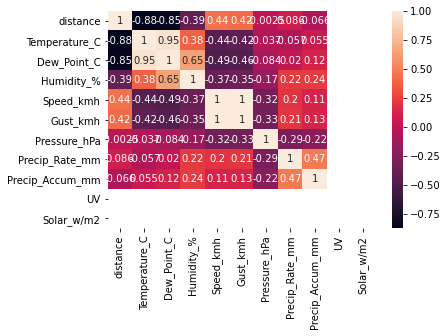

In [234]:
sns.heatmap(day_agg.corr(), annot=True)

Text(0, 0.5, 'Distance')

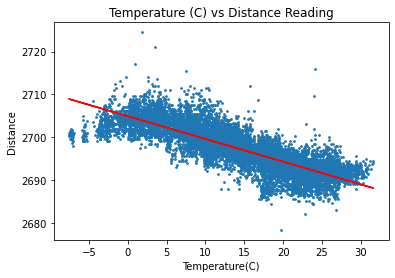

In [241]:
x_1 = night_clean['Temperature_C']
x_2 = night_clean['Humidity_%']
y = night_clean['distance']

plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

Text(0, 0.5, 'Distance')

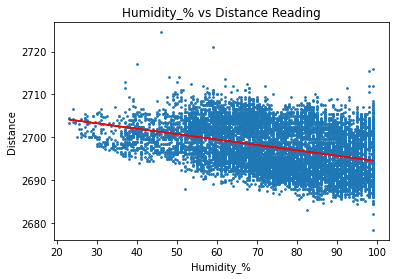

In [242]:
plt.scatter(x_2, y, s=3)
m, b = np.polyfit(x_2, y, 1)
plt.plot(x_2, m*x_2 + b, color='red')
plt.title('Humidity_% vs Distance Reading')
plt.xlabel('Humidity_%')
plt.ylabel('Distance')

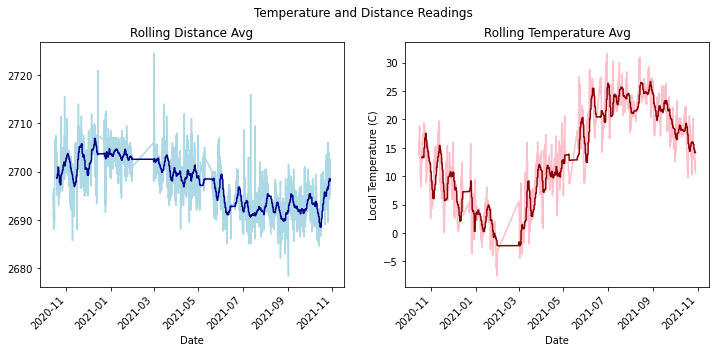

In [237]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

night_clean['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
night_clean['distance'].rolling(180).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Rolling Distance Avg')
plt.ylabel('Distance Reading')

night_clean['Temperature_C'].plot(label='Temp', color='pink', ax=ax[1])
night_clean['Temperature_C'].rolling(180).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Temperature and Distance Readings')
ax[1].set_title('Rolling Temperature Avg')
plt.ylabel('Local Temperature (C)')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
    plt.xlabel('Date')

## Average Daily Distance Measurements

In [238]:
day_agg = night_clean.groupby(night_clean.index.date).mean()

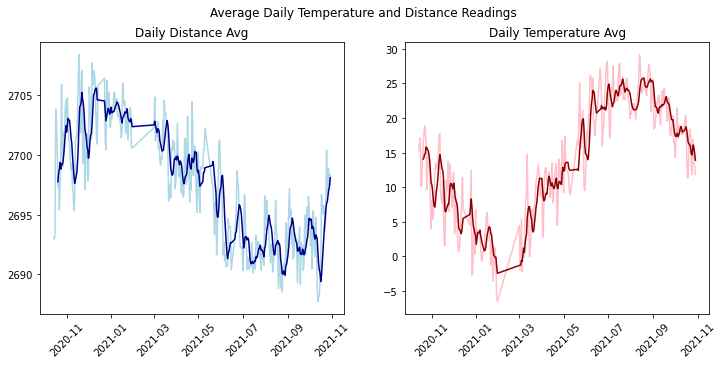

In [239]:
fig, ax = plt.subplots(1,2, figsize= (12,5))

day_agg['distance'].plot(label='Dist', color='lightblue', ax=ax[0])
day_agg['distance'].rolling(7).mean().plot(label='Dist', color='darkblue', ax=ax[0])
ax[0].set_title('Daily Distance Avg')

day_agg['Temperature_C'].plot(label='Temp', color='pink', ax=ax[1])
day_agg['Temperature_C'].rolling(7).mean().plot(label='Temp', color='darkred', ax=ax[1])
plt.suptitle('Average Daily Temperature and Distance Readings')
ax[1].set_title('Daily Temperature Avg')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation=45)

In [240]:
from statsmodels.tsa.stattools import adfuller

series=day_agg.distance
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n')
    
if result[1] < 0.05:
    print("The data is stationary")
else:
    print('The data is not stationary')

ADF Statistic: -0.988377
p-value: 0.757480
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


The data is not stationary


Text(0.5, 1.0, 'Overnight Temperature - Oct 31')

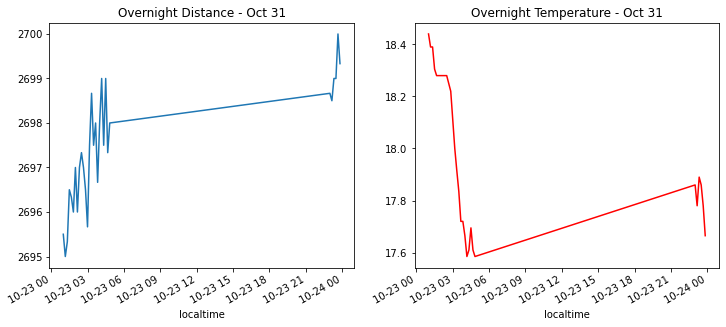

In [243]:
fig, ax = plt.subplots(1,2, figsize=(12,5))

night_clean.iloc[300:330]['distance'].plot(ax=ax[0])
ax[0].set_title('Overnight Distance - Oct 31')
night_clean.iloc[300:330]['Temperature_C'].plot(ax=ax[1], c='red')
ax[1].set_title('Overnight Temperature - Oct 31')

# Time Series Testing

In [244]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

In [245]:
(night_clean['distance'].rolling(50).mean()[-1]) - (night_clean['distance'].rolling(50).mean()[50])

4.900000000000091

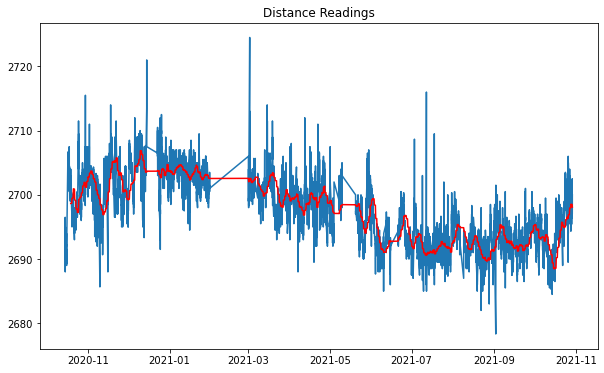

In [247]:
plt.figure(figsize = (10,6))
plt.plot(night_clean.index,night_clean.distance, label = 'distance')
plt.plot(night_clean.index,night_clean.distance.rolling(window = 180).mean(), label = 'distance', color = 'red')
plt.title('Distance Readings')
plt.show()

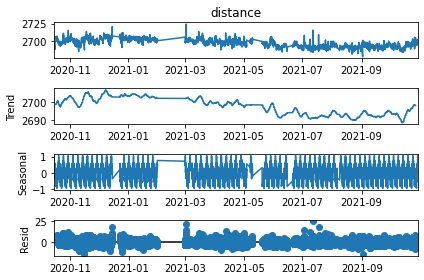

In [249]:
res = sm.tsa.seasonal_decompose(night_clean['distance'],model='additive',freq=180)
res.plot()
plt.show()

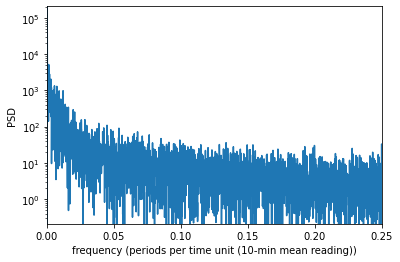

Strongest period length = 180.36507936507934


In [250]:
f, PSD = scipy.signal.periodogram(night_clean.distance)
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (10-min mean reading))')
plt.ylabel('PSD')
plt.xlim(0,0.25) #show frequencies within 1/4..1/200
plt.ylim(max(PSD)/1e6,max(PSD)) #show strength up to 1e-6 of the max
#filter outputs - periods shorter than 4 years
PSD = PSD[f>0.005]
f = f[f>0.005]
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period
#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

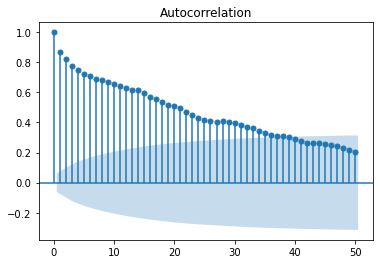

In [251]:
plot_acf(night_clean.distance[:1000], lags = 50);

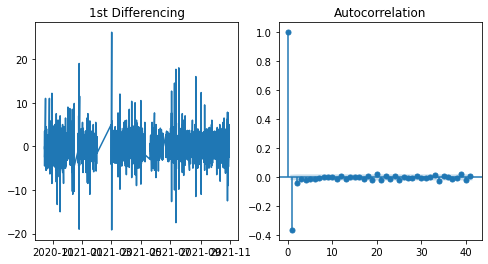

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))
axes[0].plot(night_clean.distance.diff()); axes[0].set_title('1st Differencing')
plot_acf(night_clean.distance.diff().dropna(), ax=axes[1])

plt.show()

In [253]:
from statsmodels.tsa.stattools import adfuller

series=night_clean.distance
result = adfuller(series)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

print('\n')
    
if result[1] < 0.05:
    print("The data is stationary")
else:
    print('The data is not stationary')

ADF Statistic: -5.578410
p-value: 0.000001
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


The data is stationary


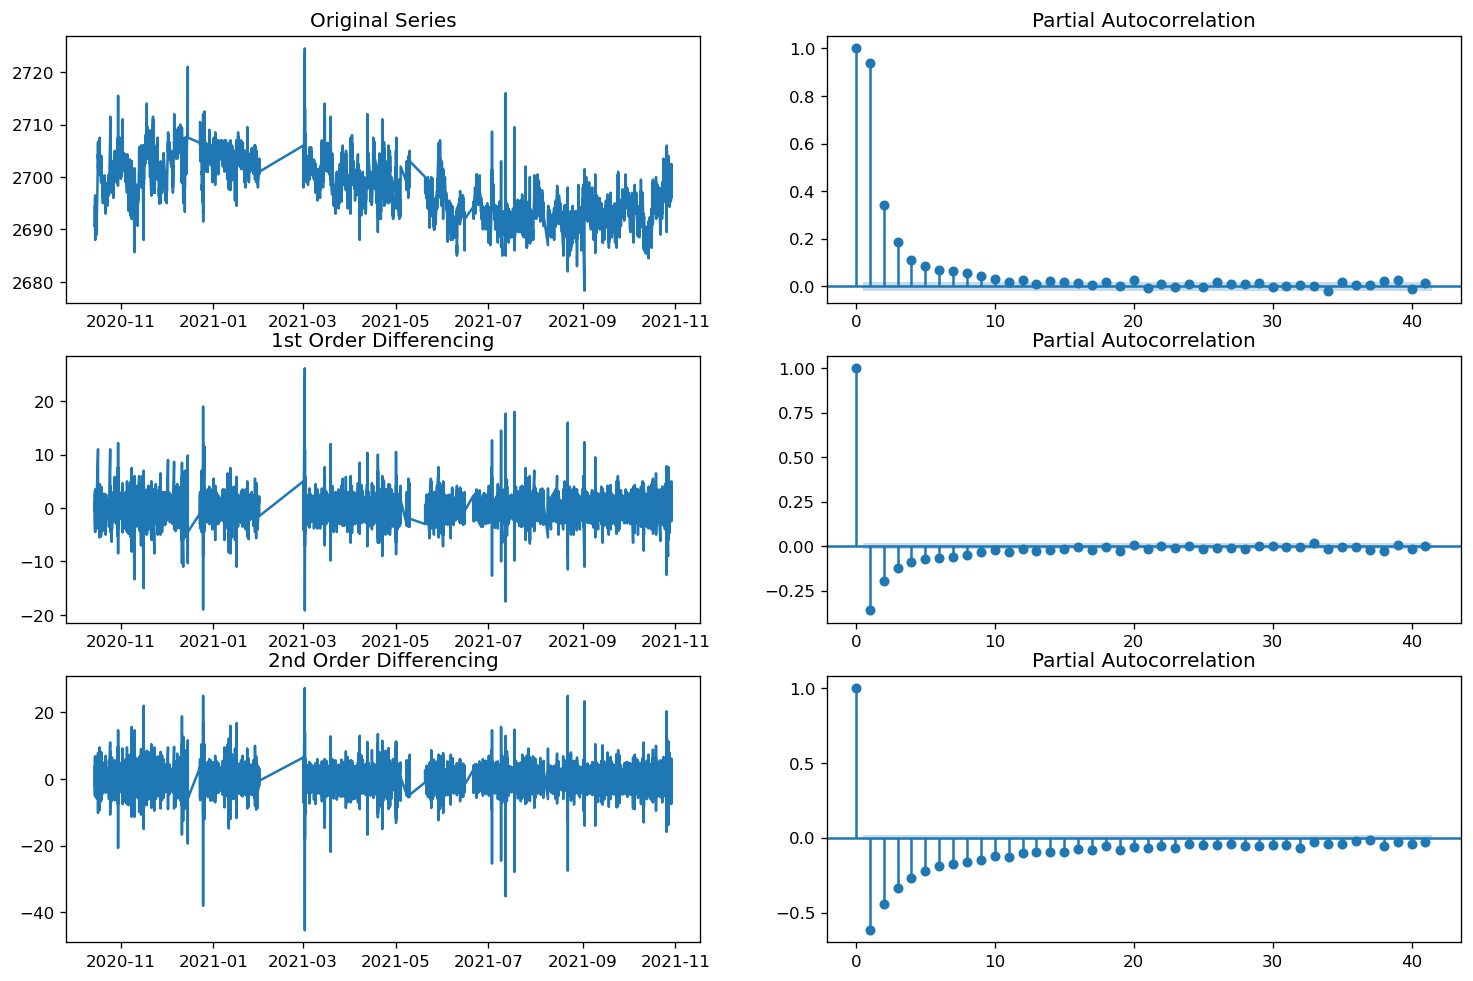

In [254]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(15,10), 'figure.dpi':120})
# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(night_clean.distance); axes[0, 0].set_title('Original Series')
plot_pacf(night_clean.distance, ax=axes[0, 1])
axes[0, 1].set_title('Partial Autocorrelation')
# 1st Differencing
axes[1, 0].plot(night_clean.distance.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_pacf(night_clean.distance.diff().dropna(), ax=axes[1, 1])
axes[1, 1].set_title('Partial Autocorrelation')
# 2nd Differencing
axes[2, 0].plot(night_clean.distance.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_pacf(night_clean.distance.diff().diff().dropna(), ax=axes[2, 1])
axes[2, 1].set_title('Partial Autocorrelation')

plt.show()

                             ARIMA Model Results                              
Dep. Variable:             D.distance   No. Observations:                 6999
Model:                 ARIMA(1, 1, 3)   Log Likelihood              -13747.758
Method:                       css-mle   S.D. of innovations              1.725
Date:                Sat, 30 Oct 2021   AIC                          27507.517
Time:                        14:41:14   BIC                          27548.638
Sample:                             1   HQIC                         27521.686
                                                                              
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const             4.336e-05      0.006      0.007      0.994      -0.012       0.012
ar.L1.D.distance     0.6914      0.070      9.886      0.000       0.554       0.829
ma.L1.D.distance    -1.1944 

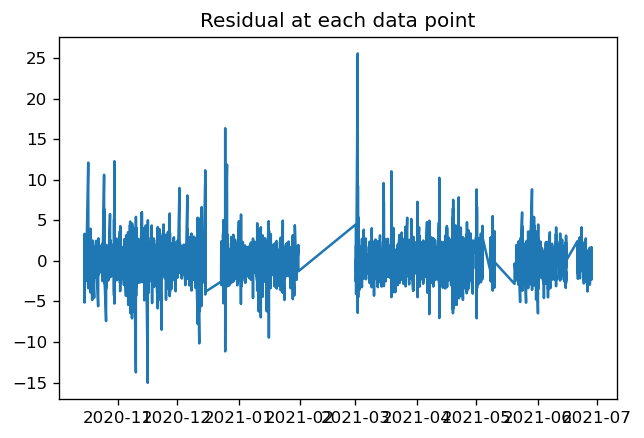

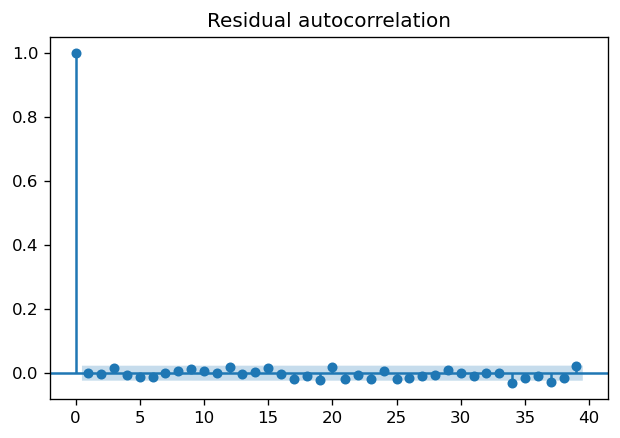

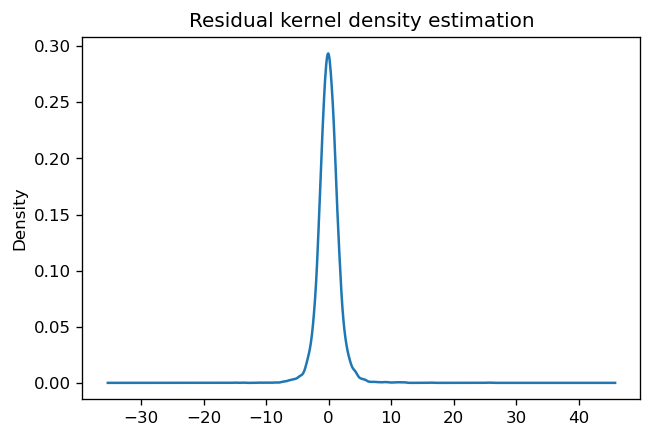

                 0
count  6999.000000
mean      0.000442
std       1.725259
min     -15.033080
25%      -0.931248
50%      -0.028823
75%       0.882675
max      25.557958
p value is  0.0
null hypothesis: residuals come from a normal distribution
The null hypothesis can be rejected


In [287]:
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})

P=3
D=1
Q=1

# fit model
N=7000
series = night_clean['distance']
model = ARIMA(series[:N], order=(Q,D,P))
model_fit = model.fit(disp = 0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
# plt.figure(figsize = (6,4))
plt.plot(residuals)
plt.title('Residual at each data point')
plot_acf(residuals)
plt.title('Residual autocorrelation')
plt.show()
residuals.plot(kind='kde', legend=False)
plt.title('Residual kernel density estimation')
plt.show()
print(residuals.describe())
k2, p = scipy.stats.normaltest(residuals)
alpha = 0.1
print('p value is ',p[0])

print('null hypothesis: residuals come from a normal distribution')
if p < alpha:  
    print("The null hypothesis can be rejected")
else:
    print("The null hypothesis cannot be rejected")

Text(0.5, 1.0, 'Sensor Distance Readings')

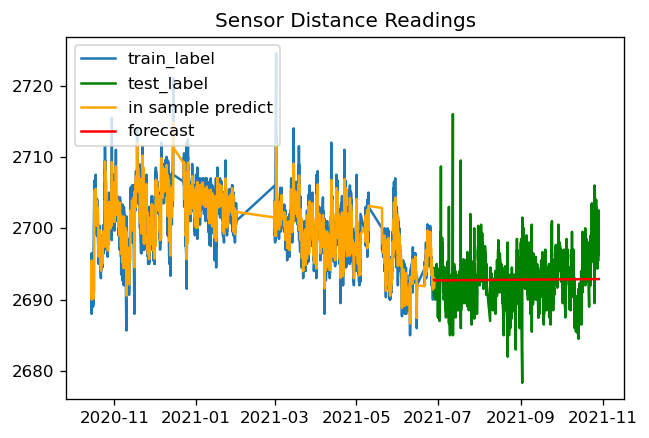

In [288]:
fc, se, conf = model_fit.forecast(steps=len(series)-N, alpha=0.05)  # 95% conf

fc_series = pd.Series(fc, index=night_clean.index[N:])

fig, ax = plt.subplots()
ax.plot(night_clean.index[:N+1],series[:N+1],label='train_label')
ax.plot(night_clean.index[N:],series[N:],color='green',label='test_label')
ax.plot(night_clean.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),color='orange',label='in sample predict')
ax.plot(fc_series, label='forecast', color='red')
#ax.fill_between(df.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15)
ax.legend(loc='upper left')
plt.title('Sensor Distance Readings')

# ML Testing

In [266]:
#import xgboost
from sklearn.metrics import confusion_matrix
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, plot_roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Temperature Only

In [267]:
#### Temperature Only

y1 = night_clean['distance']
X_temp = pd.DataFrame(night_clean['Temperature_C'])

In [268]:
X_train_temp, X_test_temp, y_train1, y_test1 = train_test_split(X_temp, y1, test_size=0.3)

In [269]:
lm_temp = sm.OLS(y_train1, sm.add_constant(X_train_temp)).fit()
lm_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 1.821e+04
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:34:48   Log-Likelihood:                -19926.
No. Observations:                7954   AIC:                         3.986e+04
Df Residuals:                    7952   BIC:                         3.987e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2704.8515      0.065   4.19e+04      0.000    2704.725    2704.978
Temperature_C    -0.5293      0.004   -134.946      0.000      -0.537      -0.522
==============================================================================
Omnibus:                      175.054   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              381.737
Skew:                          -0.065   Prob(JB):                     1.28e-83
Kurtosis:                       4.065   Cond. No.                         32.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [270]:
pred = lm_temp.predict(sm.add_constant(X_test_temp))

r2_score(y_test1, pred)

0.6958372876155433

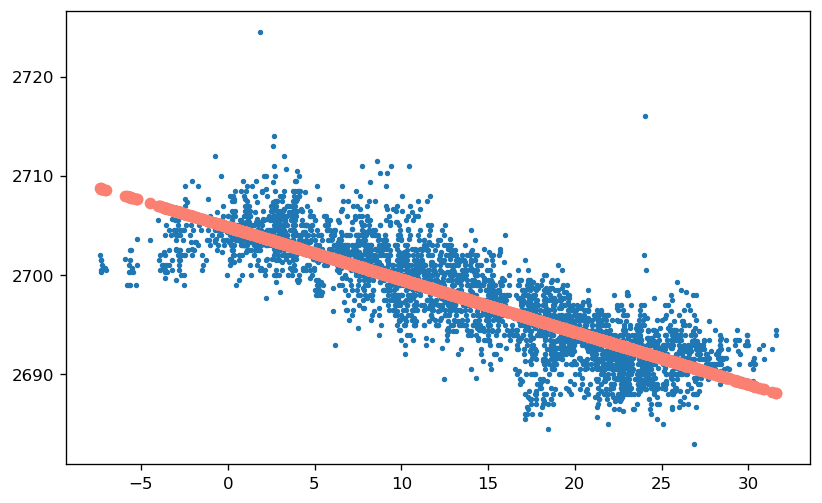

In [271]:
plt.figure(figsize=(8,5))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test_temp['Temperature_C'], y_test1, s=5)
plt.scatter(X_test_temp['Temperature_C'], pred, color ='salmon')


In [272]:
n = 4

X_poly = X_temp.copy()

for i in range(2,n+1):
    X_poly[f'x{i}'] = night_clean['Temperature_C']**i

In [273]:
X_train_poly, X_test_poly, y_train1, y_test1 = train_test_split(X_poly, y1, test_size=0.3)

In [274]:
lm_temp = sm.OLS(y_train1, sm.add_constant(X_train_poly)).fit()
lm_temp.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     5581.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:34:59   Log-Likelihood:                -19371.
No. Observations:                7954   AIC:                         3.875e+04
Df Residuals:                    7949   BIC:                         3.879e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2704.2745      0.082    3.3e+04      0.000    2704.114    2704.435
Temperature_C     0.1002      0.020      5.009      0.000       0.061       0.139
x2               -0.0631      0.003    -18.519      0.000      -0.070      -0.056
x3                0.0015      0.000      6.925      0.000       0.001       0.002
x4             1.009e-06   4.37e-06      0.231      0.818   -7.57e-06    9.58e-06
==============================================================================
Omnibus:                      431.191   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1623.463
Skew:                           0.121   Prob(JB):                         0.00
Kurtosis:                       5.200   Cond. No.                     5.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [275]:
pred_poly = lm_temp.predict(sm.add_constant(X_test_poly))

r2_score(y_test1, pred_poly)

0.7533307831393173

Text(0, 0.5, 'Distance')

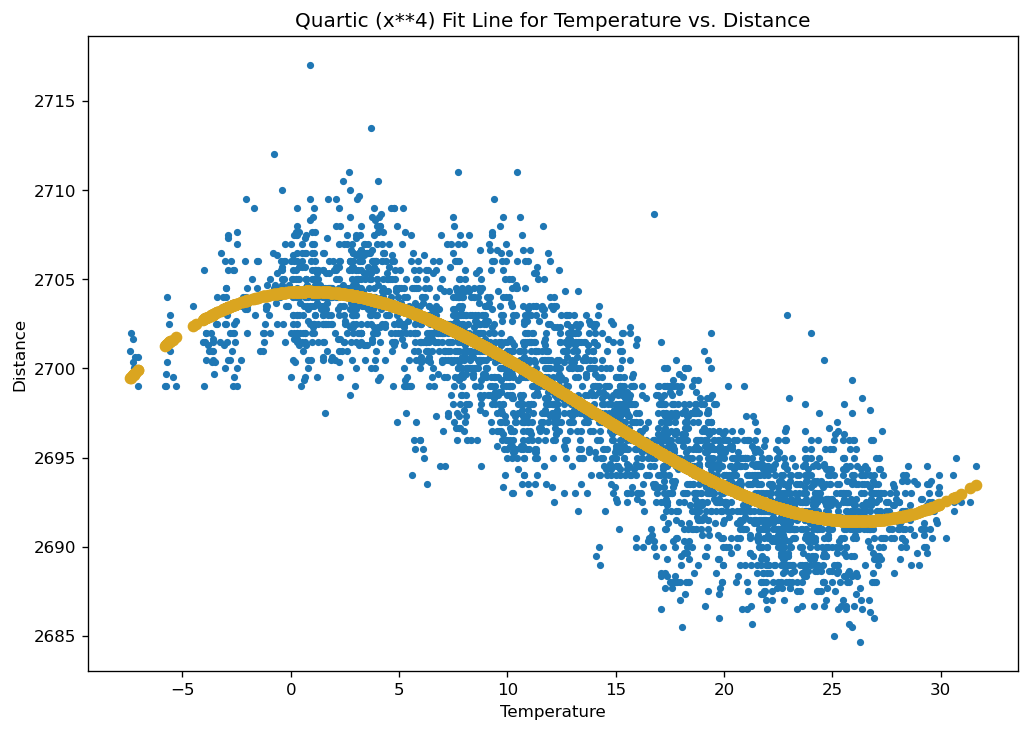

In [276]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test_poly['Temperature_C'], y_test1, s=11)
plt.scatter(X_test_poly['Temperature_C'], pred_poly, color ='goldenrod')
plt.title('Quartic (x**4) Fit Line for Temperature vs. Distance')
plt.xlabel('Temperature')
plt.ylabel('Distance')


## Temp + Humidity 

In [277]:
#### Temperature + Humdity

y1 = night_clean['distance']
X_tempH = pd.DataFrame(night_clean[['Temperature_C','Humidity_%']])

In [278]:
X_train_tempH, X_test_tempH, y_train1, y_test1 = train_test_split(X_tempH, y1, test_size=0.3)

In [279]:
lm_tempH = sm.OLS(y_train1, sm.add_constant(X_train_tempH)).fit()
lm_tempH.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                     9346.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:35:09   Log-Likelihood:                -19823.
No. Observations:                7954   AIC:                         3.965e+04
Df Residuals:                    7951   BIC:                         3.967e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2707.0420      0.158   1.72e+04      0.000    2706.733    2707.351
Temperature_C    -0.5075      0.004   -122.349      0.000      -0.516      -0.499
Humidity_%       -0.0326      0.002    -15.204      0.000      -0.037      -0.028
==============================================================================
Omnibus:                      280.243   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              818.925
Skew:                          -0.015   Prob(JB):                    1.49e-178
Kurtosis:                       4.572   Cond. No.                         382.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [280]:
pred_tempH = lm_tempH.predict(sm.add_constant(X_test_tempH))

r2_score(y_test1, pred_tempH)

0.712729820251679

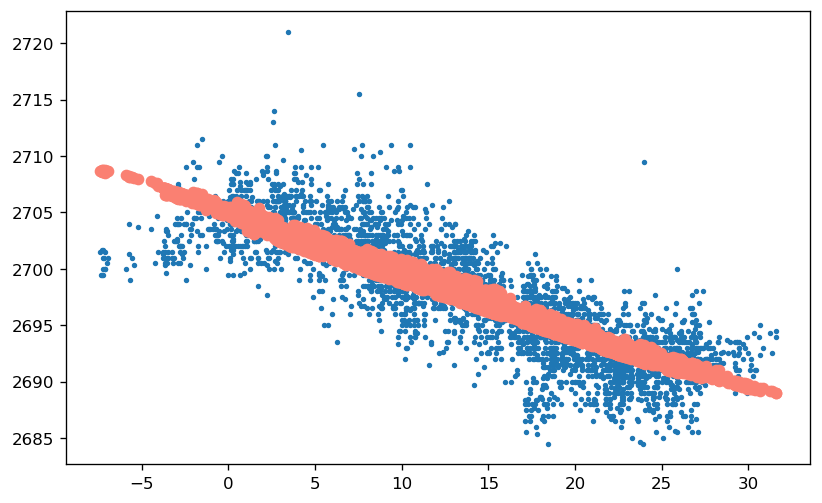

In [281]:
plt.figure(figsize=(8,5))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test_tempH['Temperature_C'], y_test1, s=5)
plt.scatter(X_test_tempH['Temperature_C'], pred_tempH, color ='salmon')

In [282]:
n = 4

X_polyH = X_tempH.copy()

for i in range(2,n+1):
    X_polyH[f'temp_x{i}'] = night_clean['Temperature_C']**i
    
for i in range(2,n+1):
    X_polyH[f'humid_x{i}'] = night_clean['Humidity_%']**i


In [336]:
X_train_polyH, X_test_polyH, y_train1, y_test1 = train_test_split(X_polyH, y1, test_size=0.3)

In [337]:
lm_tempHpoly = sm.OLS(y_train1, sm.add_constant(X_train_polyH)).fit()
lm_tempHpoly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     3108.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:52:28   Log-Likelihood:                -19051.
No. Observations:                7954   AIC:                         3.812e+04
Df Residuals:                    7945   BIC:                         3.818e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2737.9371      4.176    655.667      0.000    2729.751    2746.123
Temperature_C     0.1748      0.019      9.121      0.000       0.137       0.212
Humidity_%       -2.6658      0.281     -9.488      0.000      -3.217      -2.115
temp_x2          -0.0664      0.003    -20.761      0.000      -0.073      -0.060
temp_x3           0.0017      0.000      8.313      0.000       0.001       0.002
temp_x4       -4.904e-06   4.14e-06     -1.185      0.236    -1.3e-05    3.21e-06
humid_x2          0.0722      0.007     10.640      0.000       0.059       0.085
humid_x3         -0.0008      7e-05    -11.509      0.000      -0.001      -0.001
humid_x4       3.157e-06   2.61e-07     12.074      0.000    2.64e-06    3.67e-06
==============================================================================
Omnibus:                      568.022   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2588.759
Skew:                           0.186   Prob(JB):                         0.00
Kurtosis:                       5.770   Cond. No.                     7.26e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [338]:
pred_polyH = lm_tempHpoly.predict(sm.add_constant(X_test_polyH))

r2_score(y_test1, pred_polyH)

0.7639226594259687

Text(0, 0.5, 'Distance')

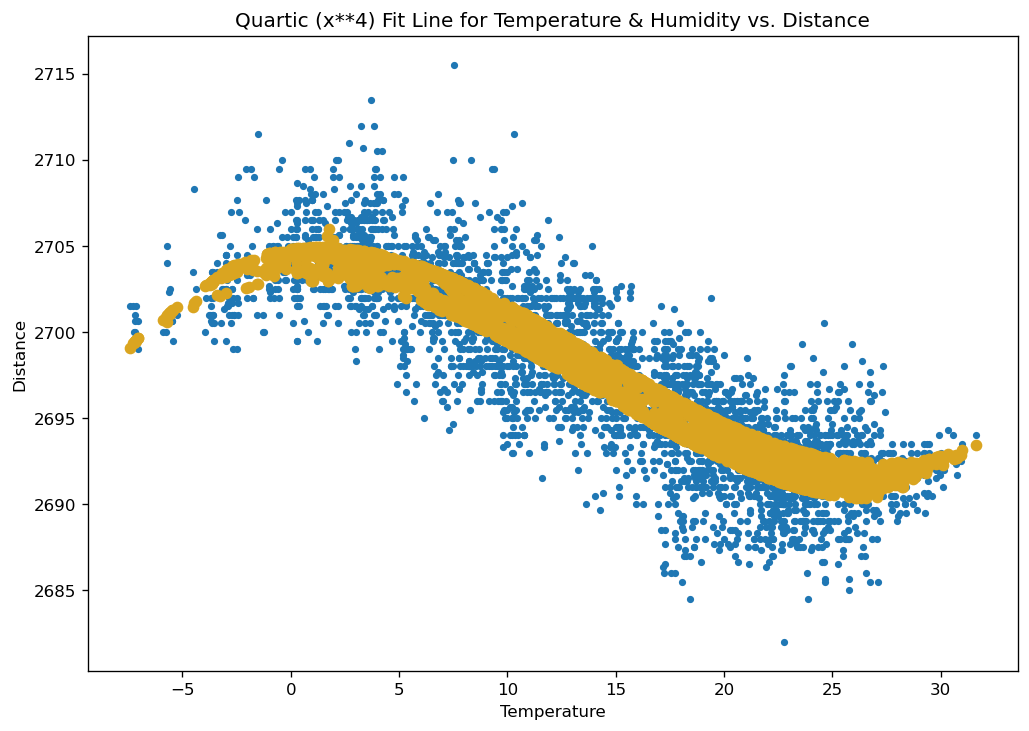

In [339]:
plt.figure(figsize=(10,7))

#plt.plot(X_train_temp, lm_temp.params[1]*X_train_temp+lm_temp.params[0], color='green')
plt.scatter(X_test_polyH['Temperature_C'], y_test1, s=11)
plt.scatter(X_test_polyH['Temperature_C'], pred_polyH, color ='goldenrod')
plt.title('Quartic (x**4) Fit Line for Temperature & Humidity vs. Distance')
plt.xlabel('Temperature')
plt.ylabel('Distance')

In [333]:
y1 = night_clean['distance']
X1 = night_clean.iloc[:,2:-2]

In [334]:
X_train1 = X1.iloc[:7000]
X_test1 = X1.iloc[7000:]
y_train1 = y1[:7000]
y_test1 = y1[7000:]

In [335]:
model = sm.OLS(y_train1, sm.add_constant(X_train1)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.566
Method:                 Least Squares   F-statistic:                     1307.
Date:                Sat, 30 Oct 2021   Prob (F-statistic):               0.00
Time:                        14:52:07   Log-Likelihood:                -17387.
No. Observations:                7000   AIC:                         3.479e+04
Df Residuals:                    6992   BIC:                         3.485e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            2702.3436      5.357    504.481      0.000    2691.843    2712.844
Dew_Point_C        -0.4635      0.006    -80.764      0.000      -0.475      -0.452
Humidity_%          0.0932      0.003     33.201      0.000       0.088       0.099
Speed_kmh          -0.2504      0.141     -1.773      0.076      -0.527       0.026
Gust_kmh            0.2382      0.101      2.369      0.018       0.041       0.435
Pressure_hPa       -0.0070      0.005     -1.340      0.180      -0.017       0.003
Precip_Rate_mm     -0.1709      0.042     -4.109      0.000      -0.252      -0.089
Precip_Accum_mm     0.0260      0.008      3.159      0.002       0.010       0.042
==============================================================================
Omnibus:                      143.771   Durbin-Watson:                   0.434
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              292.140
Skew:                           0.093   Prob(JB):                     3.65e-64
Kurtosis:                       3.983   Cond. No.                     1.57e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.57e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0.5, 1.0, 'Logistic Regression Coefficients')

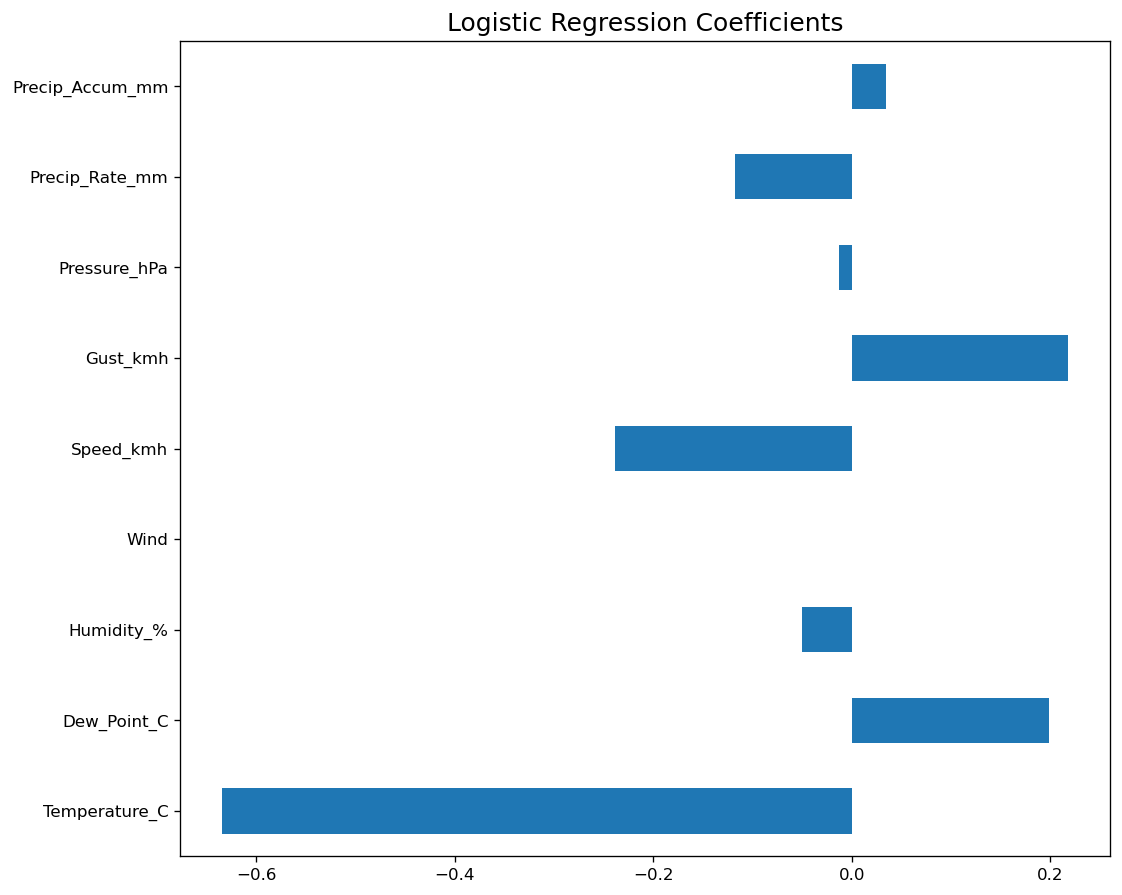

In [928]:
model.params[1:].plot.barh()
plt.title('Logistic Regression Coefficients', fontsize=15)

In [995]:
y_pred = model_day.predict(sm.add_constant(X))

r2_score(y,y_pred)

ValueError: Found input variables with inconsistent numbers of samples: [8502, 248]

In [ ]:
plt.scatter(x_1, y, s=3)
m, b = np.polyfit(x_1, y, 1)
plt.plot(x_1, m*x_1 + b, color='red')
plt.title('Temperature (C) vs Distance Reading')
plt.xlabel('Temperature(C)')
plt.ylabel('Distance')

In [587]:
df = night_clean.copy()
for i in range(1,31):
    df.insert(df.shape[1],f'distance_lag_{i}', df.distance.shift(i))

df = df.dropna()

In [588]:
scaler = StandardScaler()
night_scaled = pd.DataFrame(data=scaler.fit_transform(night_clean), columns=night_clean.columns)

In [589]:
y = df['distance']
X = df.iloc[:,2:]

In [584]:
X.head()

,Temperature_C,Dew_Point_C,Humidity_%,Wind,Speed_kmh,Gust_kmh,Pressure_hPa,Precip_Rate_mm,Precip_Accum_mm,UV,...,distance_lag_21,distance_lag_22,distance_lag_23,distance_lag_24,distance_lag_25,distance_lag_26,distance_lag_27,distance_lag_28,distance_lag_29,distance_lag_30
localtime,,,,,,,,,,,,,,,,,,,,,
2020-10-16 04:00:00-04:00,18.140,17.305,95.0,236.25,2.170,3.540,1012.19,0.0,0.0,0.0,...,2691.000000,2693.000000,2692.0,2693.0,2691.5,2694.0,2692.0,2692.333333,2691.500000,2691.333333
2020-10-16 04:10:00-04:00,18.165,17.335,95.0,247.50,1.770,2.900,1012.19,0.0,0.0,0.0,...,2692.000000,2691.000000,2693.0,2692.0,2693.0,2691.5,2694.0,2692.000000,2692.333333,2691.500000
2020-10-16 04:20:00-04:00,18.195,17.360,95.0,258.75,0.805,1.290,1012.19,0.0,0.0,0.0,...,2692.500000,2692.000000,2691.0,2693.0,2692.0,2693.0,2691.5,2694.000000,2692.000000,2692.333333
2020-10-16 04:30:00-04:00,18.280,17.500,95.0,258.75,1.130,2.010,1012.19,0.0,0.0,0.0,...,2691.666667,2692.500000,2692.0,2691.0,2693.0,2692.0,2693.0,2691.500000,2694.000000,2692.000000
2020-10-16 04:40:00-04:00,18.360,17.585,95.0,258.75,1.205,2.095,1012.19,0.0,0.0,0.0,...,2692.000000,2691.666667,2692.5,2692.0,2691.0,2693.0,2692.0,2693.000000,2691.500000,2694.000000


In [770]:
scaler = StandardScaler()
day_agg_s = pd.DataFrame(data=scaler.fit_transform(day_agg), columns=day_agg.columns)

In [818]:
y = day_agg_s['distance']
X = day_agg_s['Temperature_C']

In [819]:
X_train = X.iloc[:200]
X_test = X.iloc[200:]
y_train = y.iloc[:200]
y_test = y.iloc[200:]

In [820]:
model_day = sm.OLS(y_train, sm.add_constant(X_train)).fit()
model_day.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               distance   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.672
Method:                 Least Squares   F-statistic:                     407.9
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           5.63e-50
Time:                        14:00:47   Log-Likelihood:                -133.42
No. Observations:                 200   AIC:                             270.8
Df Residuals:                     198   BIC:                             277.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0559      0.036      1.556      0.121      -0.015       0.127
Temperature_C    -0.8143      0.040    -20.196      0.000      -0.894      -0.735
==============================================================================
Omnibus:                        4.175   Durbin-Watson:                   0.823
Prob(Omnibus):                  0.124   Jarque-Bera (JB):                4.301
Skew:                          -0.196   Prob(JB):                        0.116
Kurtosis:                       3.602   Cond. No.                         1.48
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [821]:
y_pred = model_day.predict(sm.add_constant(X_test))

r2_score(y_test,y_pred)

-0.05169641685083892

In [312]:
coefs = dict(lm_tempHpoly.params)

In [326]:
coefs

{'const': 2738.3081304698308,
 'Temperature_C': 0.15068041408604566,
 'Humidity_%': -2.702451858482832,
 'temp_x2': -0.06497391234512817,
 'temp_x3': 0.0017179543326993072,
 'temp_x4': -5.664395074615375e-06,
 'humid_x2': 0.07335207540023951,
 'humid_x3': -0.000819649628651561,
 'humid_x4': 3.2168629461544367e-06}

<AxesSubplot:xlabel='localtime'>

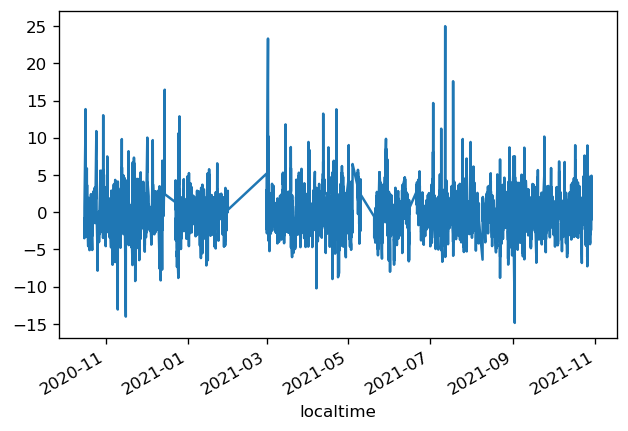

In [431]:
(night_clean['distance'] - (night_clean['distance'].rolling(50).mean()).dropna()).plot()

<AxesSubplot:>

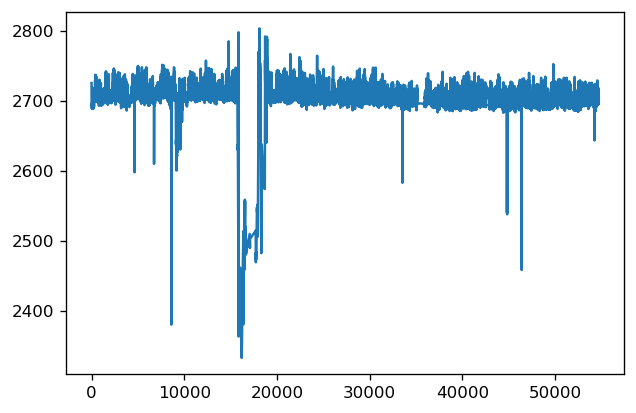

In [411]:
dist[(dist['distance'] < 3000) & (dist['distance'] > 2300)].distance.plot()